In [2]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout

# from keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet50

# from keras_applications.resnet import ResNet50

# from tensorflow.python.keras.applications.resnet50 import ResNet50
# from tensorflow.python.keras.applications import ResNet50
# from tensorflow.python.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam

# from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
# 資料路徑
DATASET_PATH  = '/content/data_pokemon'

# 影像大小
IMAGE_SIZE = (224, 224)

# 影像類別數
NUM_CLASSES = 3

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 8

# 凍結網路層數
FREEZE_LAYERS = 2

# Epoch 數
NUM_EPOCHS = 100

# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'model-resnet50-final.h5'

# 透過 data augmentation 產生訓練與驗證用的影像資料
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator()
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/valid',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

# 輸出各類別的索引值
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))

# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = net.output

from tensorflow.keras.layers import Dense, Flatten
x = Flatten()(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

Found 145 images belonging to 3 classes.
Found 49 images belonging to 3 classes.
Class #0 = fire
Class #1 = grass
Class #2 = water
94781440/94765736 [==============================] - 1s 0us/step


In [4]:
# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# 輸出整個網路結構
# print(net_final.summary())




/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [5]:
# 訓練模型
history = net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/100
18/18 [==============================] - 26s 402ms/step - loss: 2.6892 - accuracy: 0.3650 - val_loss: 2.6447 - val_accuracy: 0.2292
Epoch 2/100
18/18 [==============================] - 5s 277ms/step - loss: 2.5151 - accuracy: 0.3942 - val_loss: 2.2617 - val_accuracy: 0.4167
Epoch 3/100
18/18 [==============================] - 5s 268ms/step - loss: 2.5151 - accuracy: 0.3869 - val_loss: 2.1529 - val_accuracy: 0.4375
Epoch 4/100
18/18 [==============================] - 5s 276ms/step - loss: 2.1809 - accuracy: 0.4161 - val_loss: 2.0066 - val_accuracy: 0.4375
Epoch 5/100
18/18 [==============================] - 5s 266ms/step - loss: 2.3718 - accuracy: 0.4088 - val_loss: 1.9105 - val_accuracy: 0.4375
Epoch 6/100
18/18 [==============================] - 5s 266ms/step - loss: 2.0897 - accuracy: 0.4672 - val_loss: 1.7896 - val_accuracy: 0.3958
Epoch 7/100
18/18 [==============================] - 5s 265ms/step - loss: 1.7965 - accuracy: 0.4964 - val_loss: 1.6964 - val_accuracy: 0.416

In [6]:
# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL)

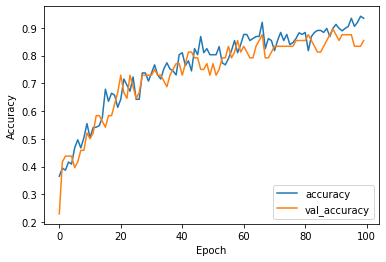

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = net_final.evaluate(test_images,  test_labels, verbose=2)

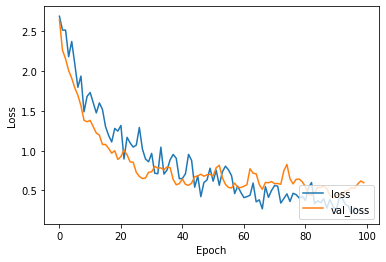

In [8]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = net_final.evaluate(test_images,  test_labels, verbose=2)

In [9]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import sys
import numpy as np
import os

def testdata(class_selected):

    # 從參數讀取圖檔路徑
    # files = sys.argv[1:]
    files = "/content/data_pokemon/test/"+ class_selected + "/"

    # 載入訓練好的模型
    net = load_model('model-resnet50-final.h5')

    cls_list = ['fire','grass', 'water']

    # 辨識每一張圖
    correct_data = 0
    all_data = 0
    for f in os.listdir(files):
    #     if f.endswith(".jpg"):
        img = image.load_img(files + f, target_size=(224, 224))
        if img is None:
            continue
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis = 0)
        pred = net.predict(x)[0]
        top_inds = pred.argsort()[::-1][:5]
        print(f)

        #print test image
        img = mpimg.imread("/content/data_pokemon/test/" + class_selected + "/" + f)
        imgplot = plt.imshow(img)
        plt.show()

        all_data = all_data + 1

        count = 0
        for i in top_inds:
            print('    {:.3f}  {}'.format(pred[i], cls_list[i]))
            if i == cls_list.index(class_selected) and count == 0:
                correct_data = correct_data + 1
            count = count + 1

    print()
    print("Accuracy: ",round(correct_data/all_data,3))

moltres.png


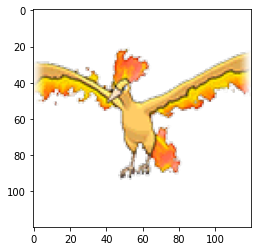

    1.000  fire
    0.000  grass
    0.000  water
ponyta.png


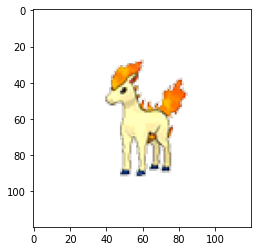

    0.778  water
    0.195  fire
    0.027  grass
monferno.png


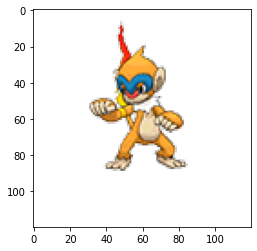

    0.966  fire
    0.031  water
    0.003  grass
pignite.png


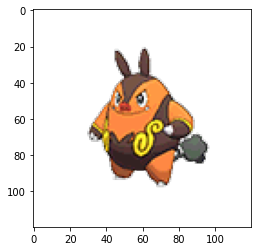

    0.584  fire
    0.415  water
    0.001  grass
pyroar.png


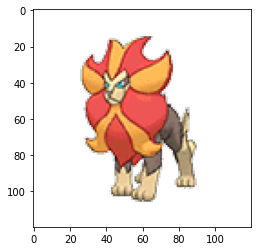

    1.000  fire
    0.000  grass
    0.000  water
simisear.png


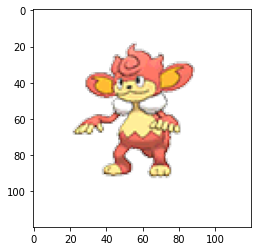

    0.996  fire
    0.003  grass
    0.000  water
ninetales.png


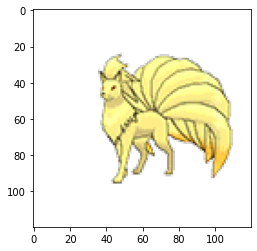

    0.666  fire
    0.302  grass
    0.032  water
rapidash.png


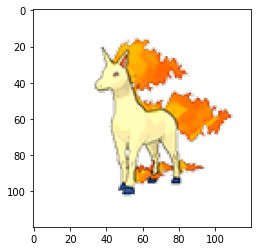

    0.994  fire
    0.005  water
    0.000  grass
oricorio-baile.jpg


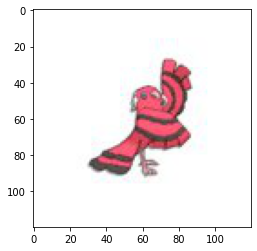

    0.933  grass
    0.066  water
    0.001  fire
numel.png


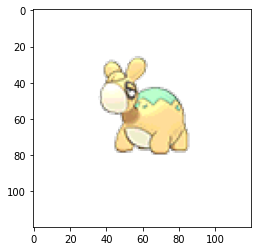

    0.594  fire
    0.358  water
    0.048  grass
pansear.png


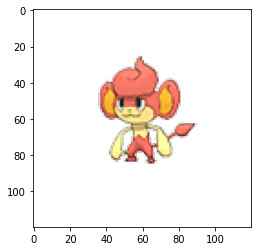

    0.999  fire
    0.001  grass
    0.000  water

Accuracy:  0.818


In [10]:
testdata("fire")

tsareena.jpg


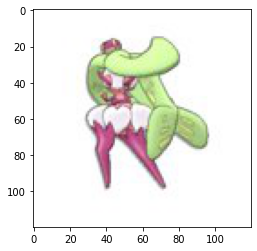

    1.000  grass
    0.000  water
    0.000  fire
victreebel.png


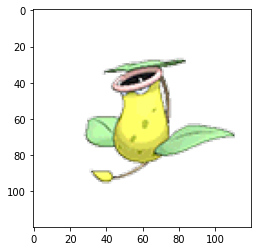

    0.764  grass
    0.236  water
    0.000  fire
tapu-bulu.jpg


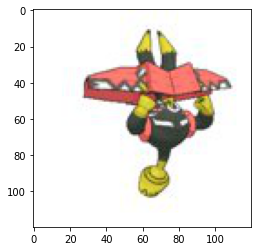

    0.986  grass
    0.011  fire
    0.003  water
tangrowth.png


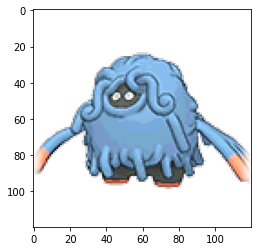

    1.000  water
    0.000  grass
    0.000  fire
virizion.png


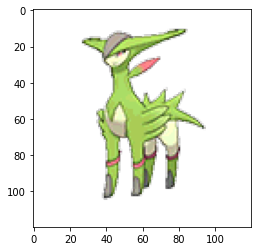

    0.950  grass
    0.049  water
    0.002  fire
tangela.png


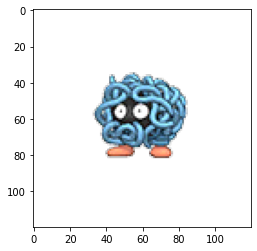

    1.000  water
    0.000  grass
    0.000  fire
turtwig.png


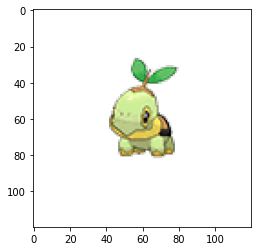

    1.000  grass
    0.000  fire
    0.000  water
treecko.png


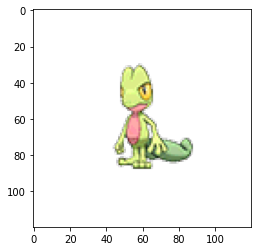

    0.853  water
    0.140  grass
    0.007  fire
vileplume.png


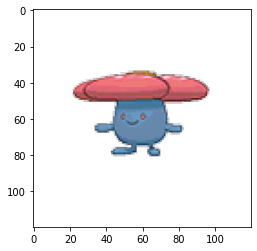

    0.737  water
    0.263  grass
    0.001  fire
sunkern.png


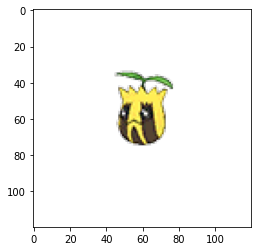

    0.848  water
    0.099  grass
    0.053  fire
weepinbell.png


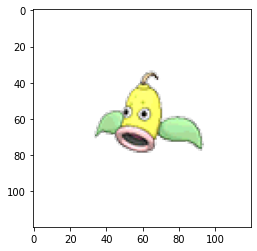

    0.637  grass
    0.363  water
    0.000  fire
tropius.png


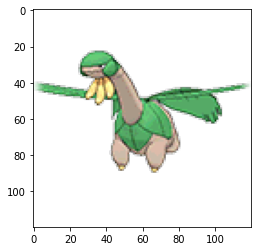

    1.000  grass
    0.000  water
    0.000  fire
torterra.png


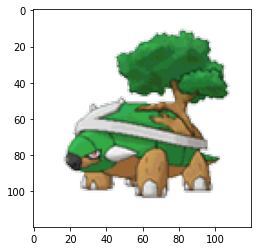

    1.000  grass
    0.000  fire
    0.000  water
whimsicott.png


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


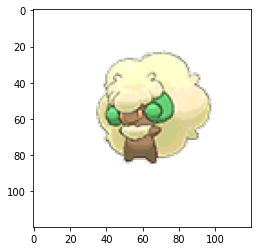

    1.000  grass
    0.000  fire
    0.000  water
venusaur.png


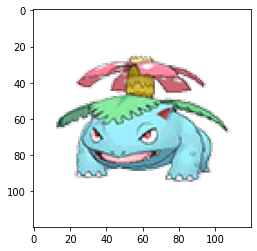

    1.000  grass
    0.000  water
    0.000  fire
sunflora.png


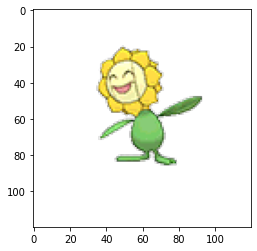

    1.000  grass
    0.000  fire
    0.000  water

Accuracy:  0.688


In [11]:
testdata("grass")

simipour.png


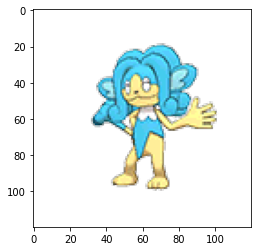

    1.000  water
    0.000  fire
    0.000  grass
remoraid.png


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


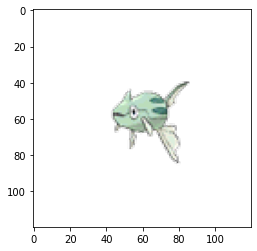

    0.788  grass
    0.212  water
    0.000  fire
psyduck.png


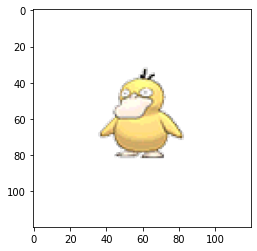

    0.822  fire
    0.174  grass
    0.004  water
shellos.png


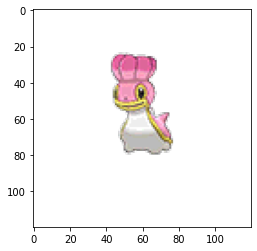

    0.964  water
    0.032  grass
    0.004  fire
poliwag.png


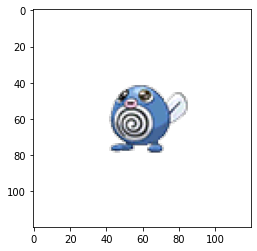

    1.000  water
    0.000  grass
    0.000  fire
seadra.png


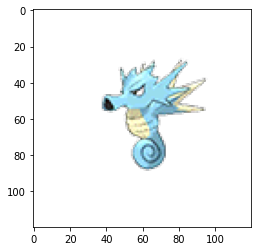

    1.000  water
    0.000  grass
    0.000  fire
pyukumuku.jpg


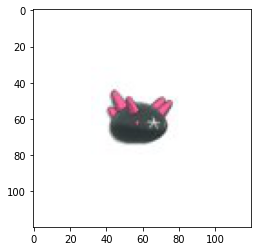

    1.000  grass
    0.000  water
    0.000  fire
qwilfish.png


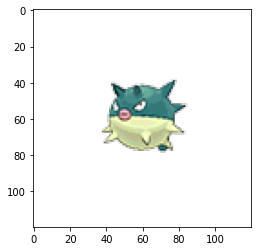

    0.877  water
    0.111  grass
    0.012  fire
sharpedo.png


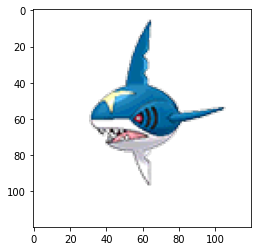

    1.000  water
    0.000  fire
    0.000  grass
seel.png


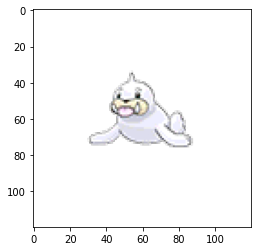

    1.000  water
    0.000  grass
    0.000  fire
prinplup.png


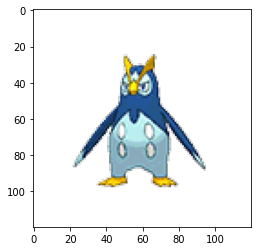

    1.000  water
    0.000  grass
    0.000  fire
popplio.jpg


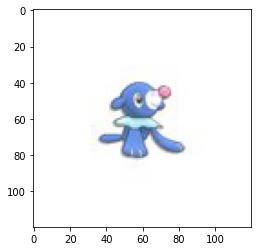

    1.000  water
    0.000  grass
    0.000  fire
shellder.png


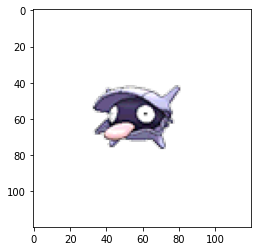

    1.000  water
    0.000  fire
    0.000  grass
politoed.png


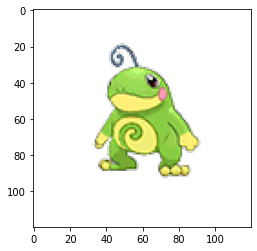

    0.548  fire
    0.350  grass
    0.102  water
quagsire.png


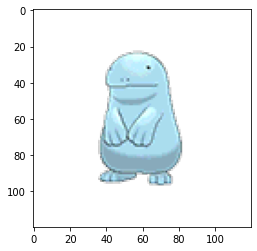

    1.000  water
    0.000  grass
    0.000  fire
piplup.png


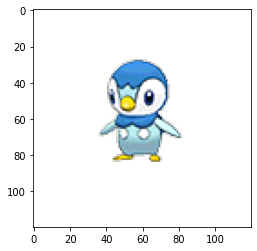

    1.000  water
    0.000  grass
    0.000  fire
poliwrath.png


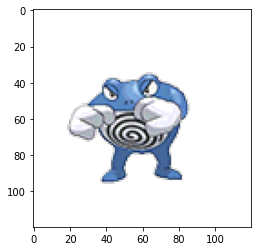

    1.000  water
    0.000  grass
    0.000  fire
primarina.jpg


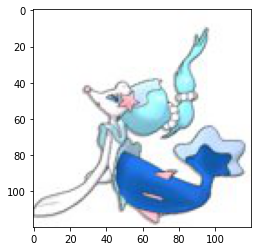

    1.000  water
    0.000  grass
    0.000  fire
poliwhirl.png


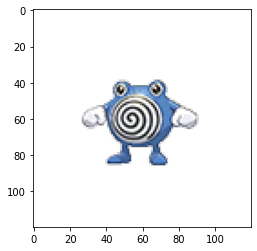

    1.000  water
    0.000  grass
    0.000  fire
seaking.png


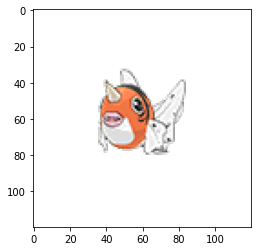

    0.895  water
    0.105  fire
    0.000  grass
relicanth.png


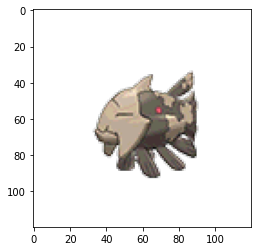

    0.461  fire
    0.406  water
    0.133  grass
samurott.png


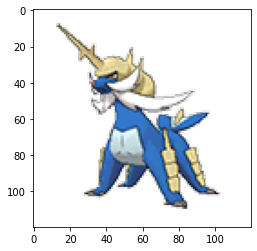

    1.000  water
    0.000  fire
    0.000  grass
seismitoad.png


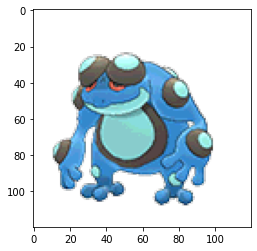

    1.000  water
    0.000  grass
    0.000  fire

Accuracy:  0.783


In [12]:
testdata("water")